In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [112]:
df = pd.read_csv('EtherPriceHistory(USD).csv')

In [113]:
df[0:5]

,Date(UTC),UnixTimeStamp,Value
0,7/30/2015,1438214400,0.0
1,7/31/2015,1438300800,0.0
2,8/1/2015,1438387200,0.0
3,8/2/2015,1438473600,0.0
4,8/3/2015,1438560000,0.0


In [114]:
#df = pd.read_csv('formatted_datetime_eth_pricedata.csv')
df = df[13:]

In [115]:
date = pd.to_datetime(df['Date(UTC)'])
price = df['Value']

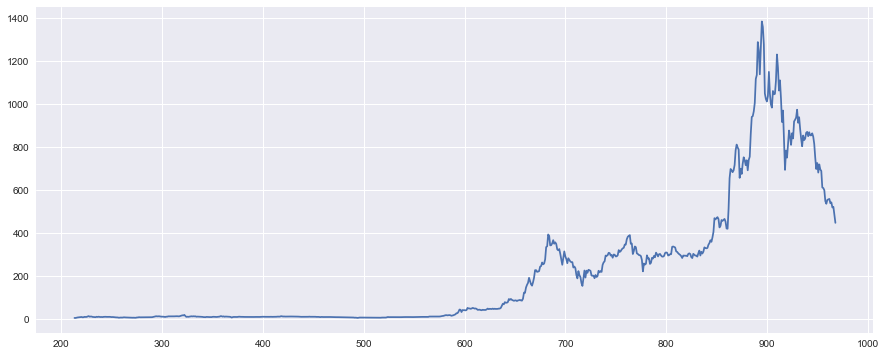

In [116]:
plt.plot(price[200:])

In [117]:
type(date), type(price)

(pandas.core.series.Series, pandas.core.series.Series)

In [118]:
df['Date'] = pd.to_datetime(df['Date(UTC)'],infer_datetime_format=True)
date = df['Date']

In [119]:
price.index = date

In [120]:
len(date), len(price)

(956, 956)

In [121]:
price.index = date

In [122]:
from statsmodels.tsa.arima_model import ARIMA

##### looking at price

In [123]:
price[0:5]

Date
2015-08-12    1.29
2015-08-13    1.88
2015-08-14    1.79
2015-08-15    1.79
2015-08-17    1.30
Name: Value, dtype: float64

In [124]:
len(price)

956

In [125]:
0.7*len(price)

669.1999999999999

### kaggle notebook

In [126]:
max(price)

1385.02

In [127]:
stuff2 = price[price == max(price)]

In [128]:
stuff2

Date
2018-01-13    1385.02
Name: Value, dtype: float64

In [129]:
price1 = price['2015-08-12':'2018-01-13']

In [130]:
price2 = price['2018-01-13':]

price1 and price 2 need to go through a test train split

then we will make two models. one for each

this will also have to be done on the differenced 
data due to stationarity

### First price 1, upslope

In [131]:
len(price1) #upsloope length

883

In [132]:
len(price2) #downslope length

74

ok we need to take price 1 and do a test train split

In [133]:
price1_train = price1[:700]

In [134]:
ts_logtransformed = np.log(price1_train)

In [135]:
price1_test = price1[700:]

In [136]:
price1[700]

224.15

In [137]:
len(price1_test)

183

In [138]:
price1_test[price1_test == 224.15]

Date
2017-07-12    224.15
Name: Value, dtype: float64

In [139]:
price1_test[price1_test == 1385.02]

Date
2018-01-13    1385.02
Name: Value, dtype: float64

In [140]:
price1[700]

224.15

In [141]:
price[price == 224.15]

Date
2017-07-12    224.15
Name: Value, dtype: float64

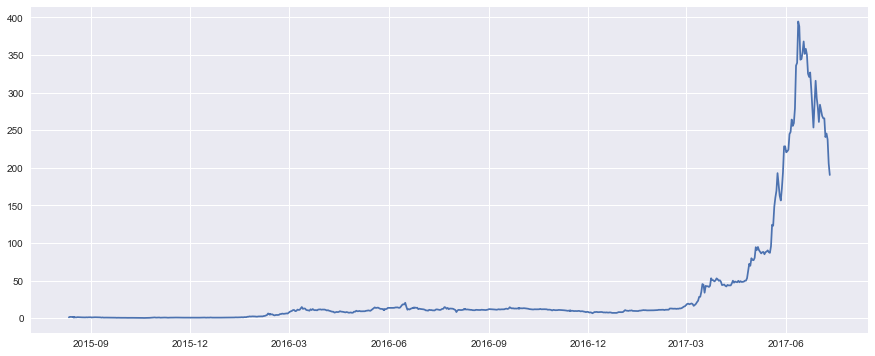

In [142]:
plt.plot(price1_train)

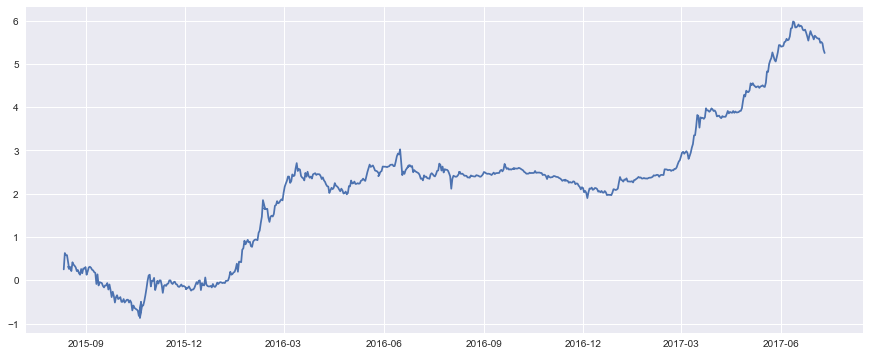

In [143]:
ts_logtransformed = np.log(price1_train)
plt.plot(ts_logtransformed)

### Rolling Mean

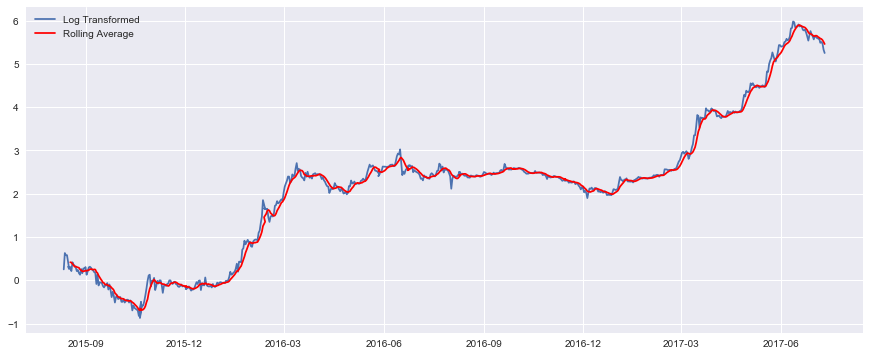

In [144]:
Rolling_average = ts_logtransformed.rolling(window = 7, center= False).mean()
plt.plot(ts_logtransformed, label = 'Log Transformed')
plt.plot(Rolling_average, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')

In [145]:
log_Rolling_difference = ts_logtransformed - Rolling_average
log_Rolling_difference.head(10)
log_Rolling_difference.tail(10)

Date
2017-07-02    0.009173
2017-07-03   -0.030139
2017-07-04   -0.048330
2017-07-05   -0.035187
2017-07-06   -0.021812
2017-07-07   -0.098499
2017-07-08   -0.070411
2017-07-09   -0.077900
2017-07-10   -0.180115
2017-07-11   -0.207628
Name: Value, dtype: float64

In [146]:
#adfuller(log_Rolling_difference) #LinAlgError: SVD did not converge

In [147]:
stuff = ts_logtransformed - Rolling_average

In [148]:
#stuff #We see Nans in the begining

In [149]:
stuff.dropna(inplace=True)

In [150]:
#stuff # now they are gone

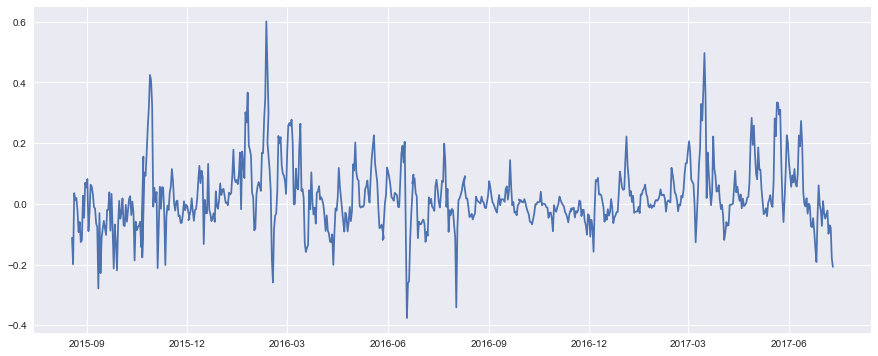

In [151]:
#log_Rolling_difference.dropna(inplace=True) 
#very important because or else does not converge

log_Rolling_difference.fillna(0)
plt.plot(log_Rolling_difference)

In [160]:
#log_Rolling_difference

In [161]:
log_Rolling_difference = log_Rolling_difference.fillna(0)

In [162]:
adfuller(log_Rolling_difference)

(-4.313839372774655,
 0.0004203280032842149,
 14,
 685,
 {'1%': -3.4399324443722814,
  '10%': -2.5690218258831052,
  '5%': -2.865768564020576},
 -1719.8709229911483)

this is a very low p value!! good sign!

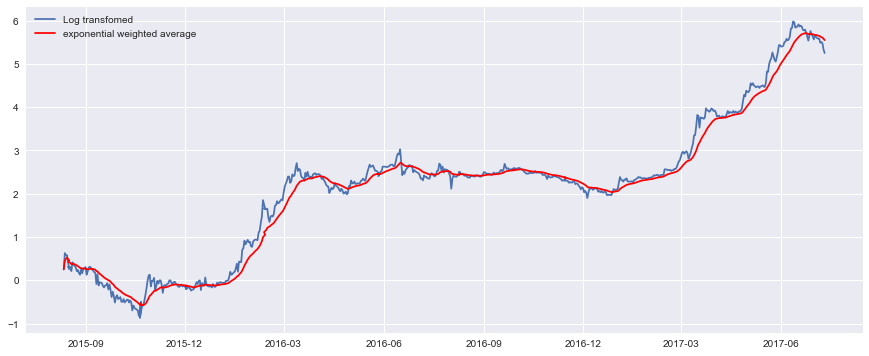

In [163]:
expwighted_avg = ts_logtransformed.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_logtransformed, label = 'Log transfomed')
plt.plot(expwighted_avg, color='red', label = 'exponential weighted average')
plt.legend(loc = 'best')

In [164]:
log_expmovwt_diff = ts_logtransformed - expwighted_avg

In [165]:
adfuller(log_expmovwt_diff)

(-3.690135512547374,
 0.004254066030430299,
 6,
 693,
 {'1%': -3.4398214107097225,
  '10%': -2.5689957624690525,
  '5%': -2.8657196436385663},
 -1645.7471360862282)

is a low p value !

### Seasonality Adjustment by Differencing

Date
2015-08-12         NaN
2015-08-13         NaN
2015-08-14         NaN
2015-08-15         NaN
2015-08-17         NaN
2015-08-16         NaN
2015-08-18         NaN
2015-08-19   -0.039531
2015-08-20   -0.212561
2015-08-21   -0.217573
Name: Value, dtype: float64

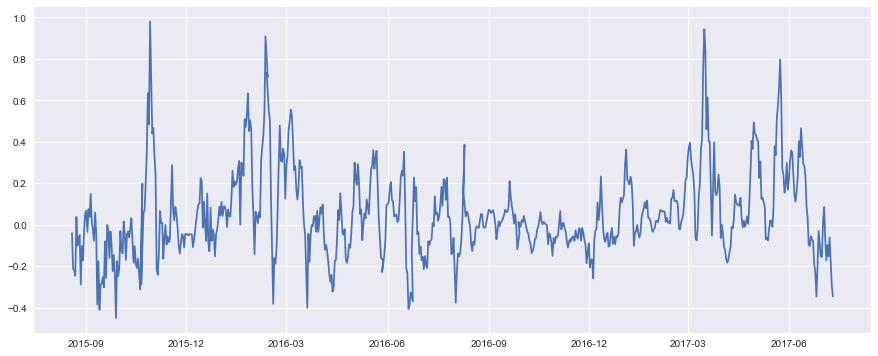

In [166]:
ts_diff_logtrans = ts_logtransformed -ts_logtransformed.shift(7) #implies 7 days
plt.plot(ts_diff_logtrans)
ts_diff_logtrans.head(10) #thats why there are nans for first 7

In [157]:
ts_diff_logtrans = ts_diff_logtrans[8:]
ts_diff_logtrans = ts_diff_logtrans.fillna(0)

In [109]:
print(ts_diff_logtrans[0])

-0.21256144198367272


In [110]:
ts_diff_logtrans[ts_diff_logtrans == -0.21256144198367272]

Date
2015-08-20   -0.212561
Name: Value, dtype: float64

In [60]:
adfuller(ts_diff_logtrans)

(-3.5929283440392354,
 0.00589767073343832,
 17,
 674,
 {'1%': -3.4400894360545475,
  '10%': -2.5690586760471605,
  '5%': -2.865837730028723},
 -1308.8375060287663)

also a low p value !

### decomposition

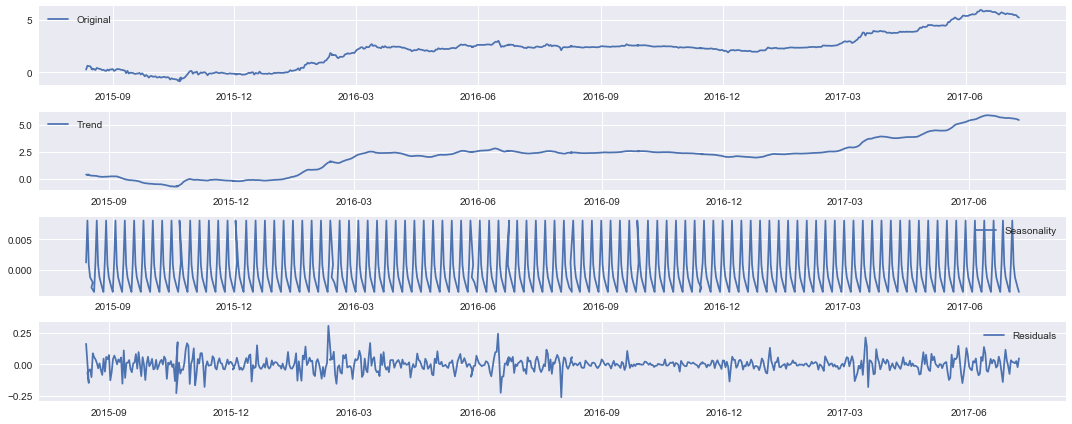

In [61]:
#done on log(price)
decomposition = seasonal_decompose(ts_logtransformed, freq=7) #seasonal period.

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 
#im gonna break these up into 3 components
#take the original, subtract of trend subract off seasonal, 
#whatever is left is residual
#aka noise

plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
#then plotted, frist is original, second is trend, third is seanoality, 4th is residuals

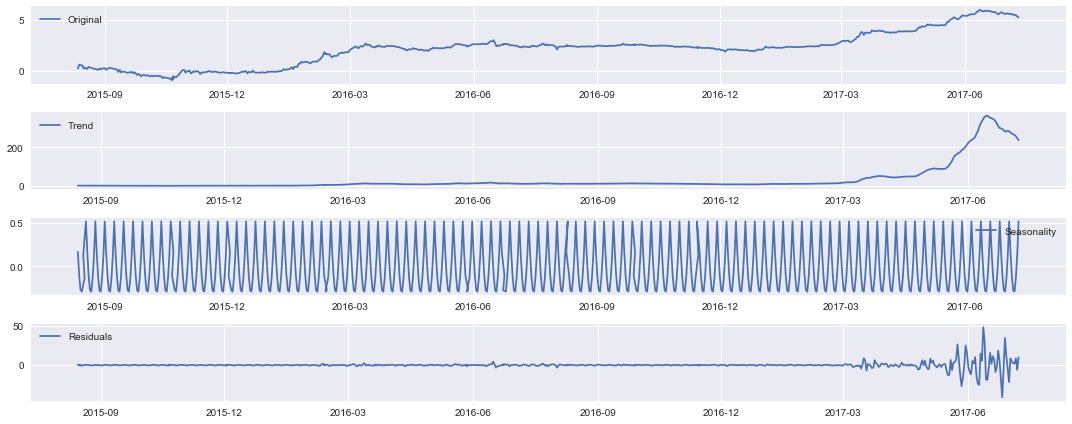

In [62]:
#done on price data
decomposition = seasonal_decompose(price1_train, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [63]:
mega_diff_series = ts_logtransformed - Rolling_average - expwighted_avg - ts_logtransformed.shift(7)


In [64]:
mega_diff_series[0:8]

Date
2015-08-12         NaN
2015-08-13         NaN
2015-08-14         NaN
2015-08-15         NaN
2015-08-17         NaN
2015-08-16         NaN
2015-08-18         NaN
2015-08-19   -0.826953
Name: Value, dtype: float64

In [65]:
#nans as expected.. thus
mega_diff_series = mega_diff_series[8:]

In [66]:
adfuller(mega_diff_series)

(-0.5588319963186463,
 0.8800156544178295,
 20,
 671,
 {'1%': -3.4401331487581754,
  '10%': -2.569068936347423,
  '5%': -2.865856987951189},
 -1298.0564363020858)

bad p-value... looks like the only good p-value is the rolling mean!

### Forecasting

In [67]:
#ACF and PACF plots:
lag_acf = acf(log_Rolling_difference, nlags=30)
lag_pacf = pacf(log_Rolling_difference, nlags=50, method='ols')

Text(0.5,1,'Autocorrelation Function')

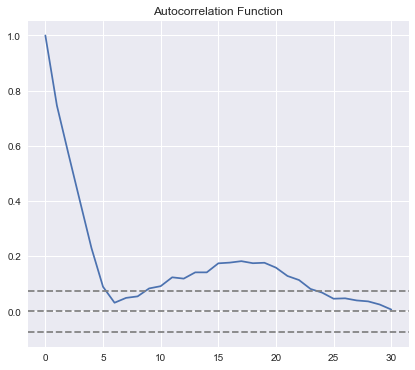

In [68]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

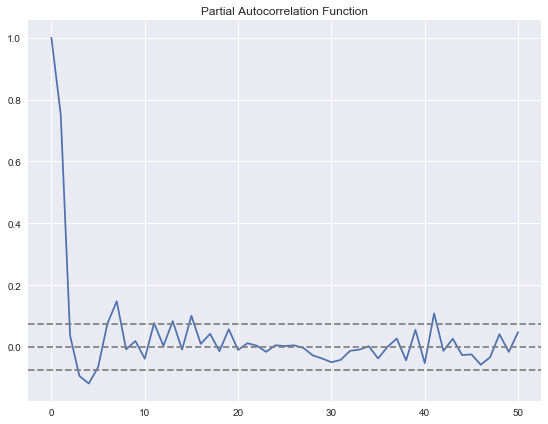

In [69]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_Rolling_difference)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

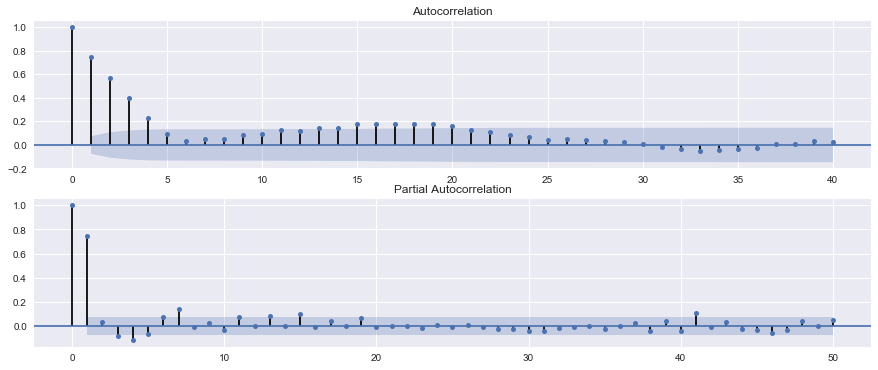

In [70]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(log_Rolling_difference, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(log_Rolling_difference, ax=pyplot.gca(), lags=50)
pyplot.show()

### directly comparing  and applying the method and reasoning: from the kaggle bitcoin notebook, to ethereum data.

Below are some observations from the plots.

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. (the blue region) These can be used to determine the ‘p’ and ‘q’ values as: the Lag values are identified from PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=3, The PACF shows a significant lag on day 2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=7,(q = 25 if we look at higher graph) since the ACF shows a significant lag for 7th day.

### Do Dickey Fuller test for stationarity

In [71]:
from statsmodels.tsa.stattools import adfuller


adfuller1 = adfuller(ts_diff_logtrans)
print(adfuller1)

(-3.5929283440392354, 0.00589767073343832, 17, 674, {'1%': -3.4400894360545475, '5%': -2.865837730028723, '10%': -2.5690586760471605}, -1308.8375060287663)


In [72]:
adfuller2 = adfuller(ts_logtransformed)
print(adfuller2)

(-0.6202872175002139, 0.8663317412117475, 17, 682, {'1%': -3.439974756130998, '5%': -2.865787205712192, '10%': -2.569031757724822}, -1506.6287824188744)


In [73]:
adfuller2

(-0.6202872175002139,
 0.8663317412117475,
 17,
 682,
 {'1%': -3.439974756130998,
  '10%': -2.569031757724822,
  '5%': -2.865787205712192},
 -1506.6287824188744)

2nd value p-value is 0.75
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.
so in ur case ist > 0.05 so we cannot reject the null hypothesis
which means ur series has a unit root
now check https://en.wikipedia.org/wiki/Unit_root_test
oh that means it is not stationary?
ugh
the gist is if ur series has a unit root its not statinary
yeah 😐
so doesnt matter what else you get
because "A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time"
if this gets violated nothing else matters

we need to use the stationary log transformed.

yeah whichever series gives u a p-value (2nd value in that adfuller) < 0.05 -
use that one and do everything on that -
also the process we just followed, you can leverage that in the future for some function and to interpret its results esepcially if its a bit complex like this one -
ok.. just wondering for when i do the predicting...what will i be predicting? -
the price itself and u can match it with the log diff of the series
u can get back the original price anyway after doing an inverse transform - 
so will i be predicting a new "log_diff_trans" and then reverse transforming that data to get price back? -
yes but only if the series is stationary when you trained the model (after applying the transformations and doing the ad fuller test) - 
refer to https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ - 
in this case they do some seasonal differncing also to make it stationary so he mentions the same, "For reference, the seasonal difference operation can be inverted by adding the observation for the same month the year before. This is needed in the case that predictions are made by a model fit on seasonally differenced data. "

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC:
-1765.3590644749481


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


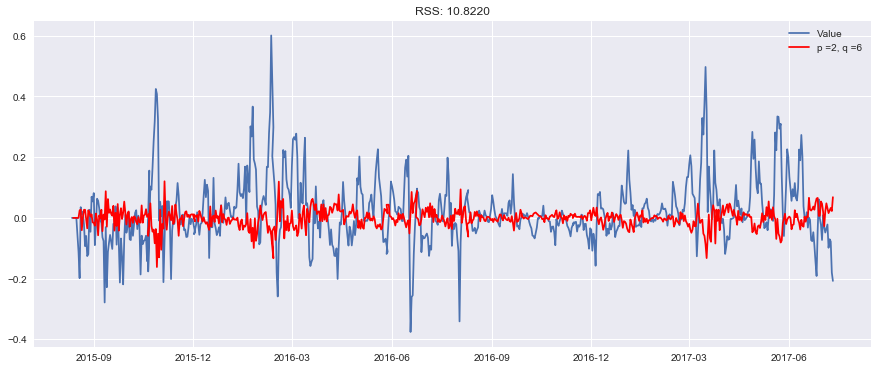

In [167]:
model1 = ARIMA(log_Rolling_difference, order=(2, 1, 6))  
results_ARIMA1 = model1.fit(trend= 'nc', disp=-1)  
plt.plot(log_Rolling_difference)
plt.plot(results_ARIMA1.fittedvalues, color='red', label = 'p =2, q =6')
RSS =results_ARIMA1.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print('AIC:')
print(results_ARIMA1.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC:
-1755.8280189227578


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


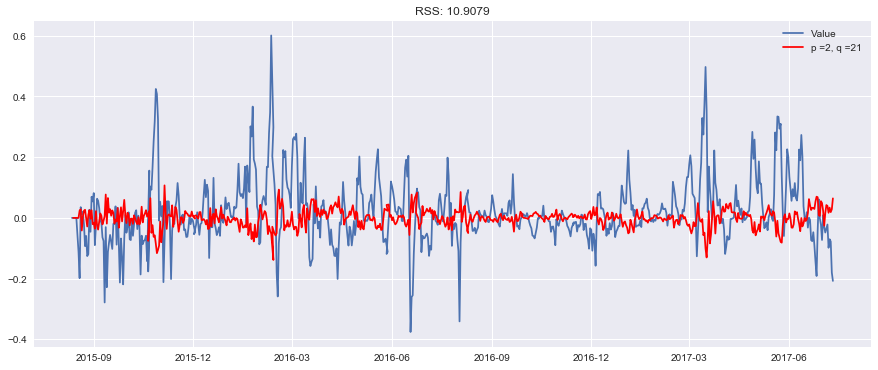

In [168]:
model2 = ARIMA(log_Rolling_difference, order=(2, 1, 5))  
results_ARIMA2 = model2.fit(trend= 'nc', disp=-1)  
plt.plot(log_Rolling_difference)
plt.plot(results_ARIMA2.fittedvalues, color='red', label = 'p =2, q =21')
RSS =results_ARIMA2.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print('AIC:')
print(results_ARIMA2.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC:
-1763.4617931423916


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


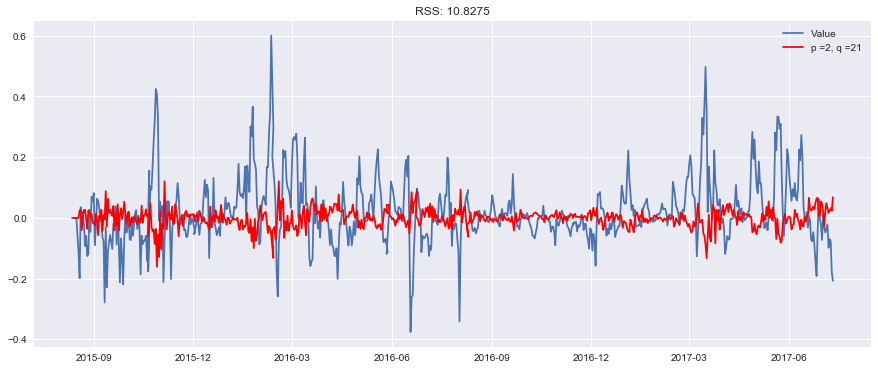

In [169]:
model3 = ARIMA(log_Rolling_difference, order=(2, 1, 7))  
results_ARIMA3 = model3.fit(trend= 'nc', disp=-1)  
plt.plot(log_Rolling_difference)
plt.plot(results_ARIMA3.fittedvalues, color='red', label = 'p =2, q =21')
RSS =results_ARIMA3.fittedvalues-log_Rolling_difference
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print('AIC:')
print(results_ARIMA3.aic)

order(2,1,6) seems to give the lowest AIC

### Testing out different parameters:
note: done on tsdifflogtrans vs ts_logtransformed... ACF and PACF were done on diff, so it makes sense to train the model on diff

### now predict price1:

In [77]:
print(price[700]) #this is the last index of price1_train
print(price[price == 224.15])


224.15
Date
2017-07-12    224.15
Name: Value, dtype: float64


In [95]:
price1_train[-1]

190.55

In [98]:
price1_test[0]

224.15

In [185]:
price1_test[price1_test == 224.15]

Date
2017-07-12    224.15
Name: Value, dtype: float64

In [96]:
price1_test[-1]

1385.02

In [97]:
price1_test[price1_test == 1385.02]

Date
2018-01-13    1385.02
Name: Value, dtype: float64

In [94]:
price1_train[price1_train == 190.55]

Date
2017-07-11    190.55
Name: Value, dtype: float64

In [78]:
#what is the last date of test? March 27th
price2[price2 == 448.78]

Date
2018-03-27    448.78
Name: Value, dtype: float64

In [82]:
price1_train[price1_train == 190.55]

Date
2017-07-11    190.55
Name: Value, dtype: float64

In [104]:
len(price1_train)

700

In [105]:
len(price1)

883

In [106]:
len(price1_test)

183

In [182]:
price1_train[699]

190.55

In [183]:
price1_test[0]

224.15

In [184]:
price[700]

224.15

In [177]:
price1_train

Date
2015-08-12      1.29
2015-08-13      1.88
2015-08-14      1.79
2015-08-15      1.79
2015-08-17      1.30
2015-08-16      1.37
2015-08-18      1.36
2015-08-19      1.24
2015-08-20      1.52
2015-08-21      1.44
2015-08-22      1.40
2015-08-23      1.35
2015-08-24      1.24
2015-08-25      1.27
2015-08-26      1.18
2015-08-27      1.14
2015-08-28      1.30
2015-08-29      1.18
2015-08-30      1.32
2015-08-31      1.31
2015-09-01      1.36
2015-09-02      1.14
2015-09-03      1.23
2015-09-04      1.35
2015-09-05      1.37
2015-09-06      1.34
2015-09-07      1.28
2015-09-08      1.26
2015-09-09      1.21
2015-09-10      1.19
               ...  
2017-06-12    394.66
2017-06-13    388.09
2017-06-14    343.84
2017-06-15    344.68
2017-06-16    353.61
2017-06-17    368.10
2017-06-18    351.53
2017-06-19    358.20
2017-06-20    350.53
2017-06-21    325.30
2017-06-22    320.97
2017-06-23    326.85
2017-06-24    304.54
2017-06-25    279.36
2017-06-26    253.68
2017-06-27    286.14
2017-06-

In [170]:
results_ARIMA1.predict(start=699 , end=883)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


699    6.823264e-02
700    5.486379e-02
701    4.095235e-02
702    2.344451e-02
703    5.739204e-02
704    2.934049e-02
705    1.914178e-02
706   -4.933481e-03
707    7.316655e-03
708   -5.541383e-03
709    5.007330e-03
710   -4.282495e-03
711    3.723272e-03
712   -3.221011e-03
713    2.790686e-03
714   -2.416757e-03
715    2.093218e-03
716   -1.812918e-03
717    1.570172e-03
718   -1.359923e-03
719    1.177829e-03
720   -1.020117e-03
721    8.835227e-04
722   -7.652185e-04
723    6.627552e-04
724   -5.740119e-04
725    4.971513e-04
726   -4.305825e-04
727    3.729272e-04
728   -3.229920e-04
           ...     
854   -4.392636e-12
855    3.804459e-12
856   -3.295040e-12
857    2.853832e-12
858   -2.471702e-12
859    2.140740e-12
860   -1.854093e-12
861    1.605829e-12
862   -1.390807e-12
863    1.204577e-12
864   -1.043284e-12
865    9.035874e-13
866   -7.825965e-13
867    6.778063e-13
868   -5.870477e-13
869    5.084416e-13
870   -4.403610e-13
871    3.813964e-13
872   -3.303271e-13


In [192]:
forecast = results_ARIMA1.predict(start=699 , end=883)
#need to transform the test data with log and rolling mean!

ts_logtransformed_test = np.log(price1_test)
Rolling_average_test = ts_logtransformed_test.rolling(window = 7, center= False).mean()
tranformed_test = ts_logtransformed_test - Rolling_average_test

plt.plot(forecast, color = 'green', label ='Predicted rates')
plt.plot(tranformed_test, color = 'red',label = 'Observed from test data')
plt.legend(loc='best')

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: view limit minimum -36101.4 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1080x432 with 1 Axes>

In [190]:
#remember we took test and train up to the peak only... so 
#this makes sense 
#'2017-07-12' should be the last of the train, 
#first date should be inclusive not sure about last date...

date1  = pd.to_datetime('2017-07-12',infer_datetime_format=True)
date2  = pd.to_datetime('2018-01-13',infer_datetime_format=True)

results_ARIMA1.predict(start=date1 , end=date2)

ValueError: There is no frequency for these dates and date 2017-07-12 00:00:00 is not in dates index. Try giving a date that is in the dates index or use an integer